In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import math
from lmfit import Model, Parameters
import matplotlib as mpl
from scipy import stats
mpl.rcParams['pdf.fonttype'] = 42


In [2]:
# 这是事后拼图的时候发现拼一起字太小，就改了下字体大小。
plt.rcParams.update({
    'font.size': 16,          # 默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 33,    # x轴刻度标签字体大小
    'ytick.labelsize': 33,    # y轴刻度标签字体大小
    'legend.fontsize': 16     # 图例字体大小
})


# 数据导入

In [ ]:
df = pd.read_excel('../data/weekly_cases_by_year_2019_2023.xlsx')
df

,Date,Case
0,2019-01-07,1
1,2019-01-14,0
2,2019-01-21,0
3,2019-01-28,1
4,2019-02-04,1
...,...,...
256,2023-12-04,0
257,2023-12-11,0
258,2023-12-18,0
259,2023-12-25,0


In [4]:
import pandas as pd

# 假设你已经有一个名为 df 的 DataFrame
# 确保 'Date' 列是 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 获取所有年份
years = df['Date'].dt.year.unique()

# 创建每一年的 DataFrame
for year in years:
    globals()[f'df_{year}'] = df[df['Date'].dt.year == year]

# 现在你可以通过 df_2019、df_2020 等访问相应年份的数据

I_2019 = df_2019['Case']
I_2020 = df_2020['Case']
I_2021 = df_2021['Case']
I_2022 = df_2022['Case']
I_2023 = df_2023['Case']

In [5]:
I_2019.sum()

443

# 数据拟合

## 2023

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 340
    # data points      = 28
    # variables        = 4
    chi-square         = 4523.26147
    reduced chi-square = 188.469228
    Akaike info crit   = 150.373954
    Bayesian info crit = 155.702772
    R-squared          = 0.73236270
[[Variables]]
    beta0:  0.12706541 +/- 0.07732494 (60.85%) (init = 0.1)
    alpha:  1.72553454 +/- 1.36933342 (79.36%) (init = 2)
    T:      52 (fixed)
    S2_0:   797212.063 +/- 1392810.48 (174.71%) (init = 10000)
    S3_0:   1091.83881 +/- 1598.24869 (146.38%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9972
    C(alpha, S2_0)  = +0.9141
    C(beta0, alpha) = -0.8871
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 234
    # data points      = 13
    # variables        = 3
    chi-square         = 665.041271
    reduced chi

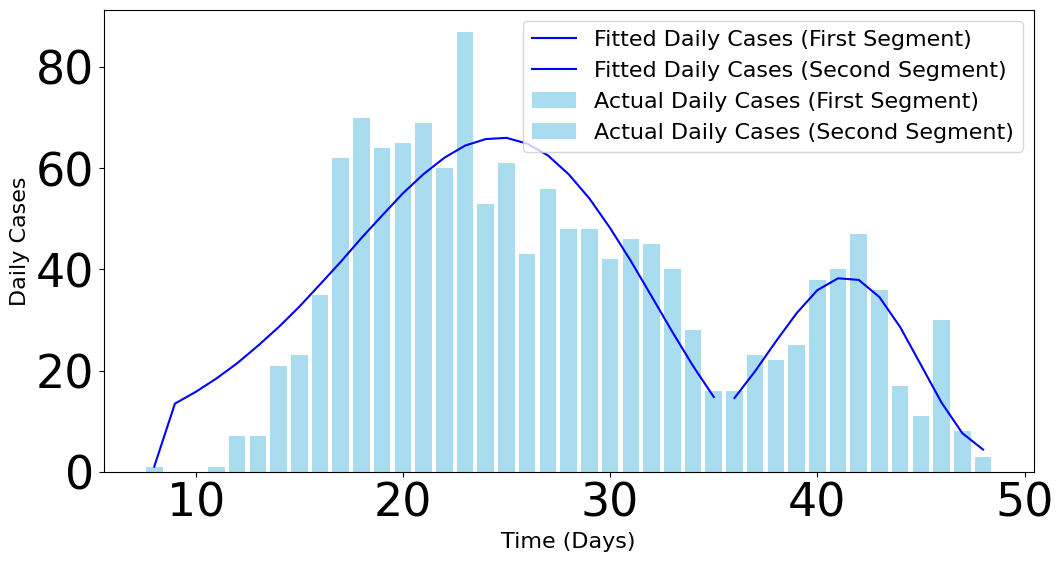

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2023[7:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2023[35:48].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(8, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 49)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 49)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 61209999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00645
    dr1 = 0.00856
    κ = 1
    p = 0.043
    f = 0.023322
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.1, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=10000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=10000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    61209999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00645
dr1 = 0.00856
κ = 1
p = 0.043
f = 0.023322
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00645
    dr1 = 0.00856
    κ = 1
    p = 0.043
    f = 0.023322
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=35)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2023 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2023 = I_2023[7:48].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2023# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2023  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)


MSE: 126.47713937001191
RMSE: 11.246205554319728
R-squared: 0.7532827795585368
MAE: 9.12031295055484
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_1356\3466602459.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [17]:
0.04619*4.33

0.2000027

In [18]:
0.00231*4.33

0.0100023

In [19]:
11/7

1.5714285714285714

meta NOT subset; don't know how to subset; dropped


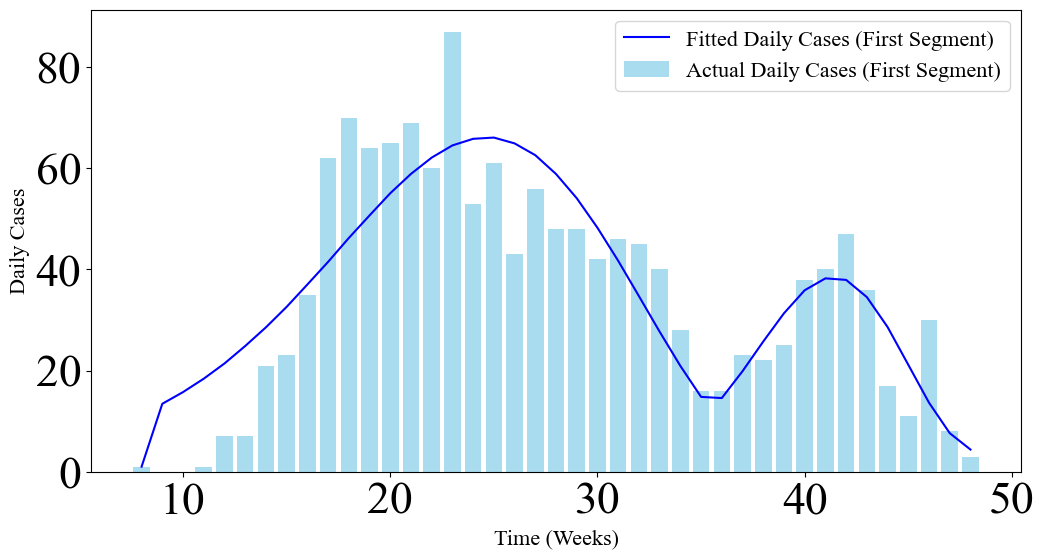

皮尔森相关系数：0.8700522029083733
p值：1.514889164886654e-13


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(8, 49), observed_cases_2023, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(8, 49), result_2023, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)

plt.savefig('../outcome/Figure/Fit/Anhui Provinces/2023.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2023, result_2023)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

In [55]:
# 这是拼图的时候发现拼一起字太小，就改了下字体大小。
# plt.rcParams.update({
#     'font.size': 16,          # 默认字体大小
#     'axes.titlesize': 16,     # 标题字体大小
#     'axes.labelsize': 16,     # 坐标轴标签字体大小
#     'xtick.labelsize': 35,    # x轴刻度标签字体大小
#     'ytick.labelsize': 35,    # y轴刻度标签字体大小
#     'legend.fontsize': 16     # 图例字体大小
# })


meta NOT subset; don't know how to subset; dropped


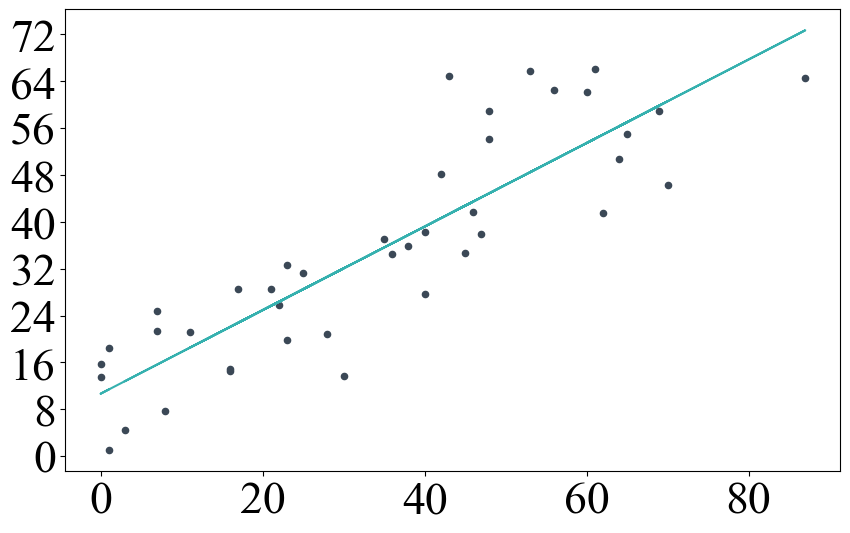

R²：0.7569908357857131


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2023)
predicted_cases = np.array(result_2023)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')

# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../outcome/Figure/Goodness of fit/Anhui Provinces/2023.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

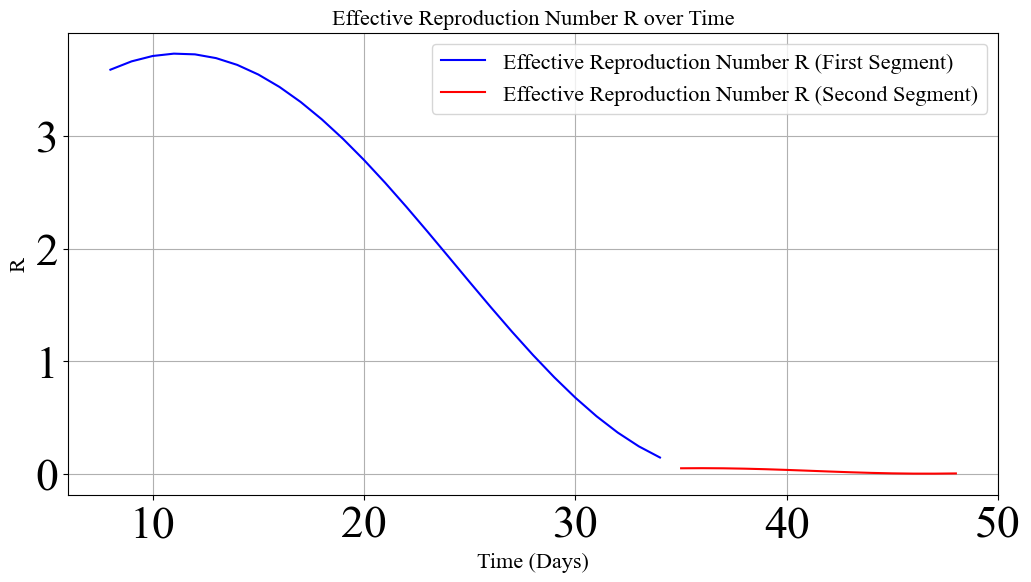

In [57]:
N1 = 61210000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(8, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
import numpy as np

def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 参数设置
beta0 = 0.003894282
alpha = 1.58080162
T = 178
t = 11  # 第一个时刻，假设 t=0

# 计算 beta1_val
beta1_val = beta_seasonal(t, beta0, alpha, T)

# 计算 beta23_val 和 beta32_val
beta23_val = 8 * beta1_val
beta32_val = 8 * beta1_val

print("beta1_val:", beta1_val)
print("beta23_val:", beta23_val)
print("beta32_val:", beta32_val)

beta1_val: 0.005567396895589987
beta23_val: 0.0445391751647199
beta32_val: 0.0445391751647199


In [59]:
N1 = 4050000
N2 = 943800.5558
N3 = 94401.0781

large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
large_num2 = 3897787739929702299663151799028731409.0

term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
term2

-10.920194002031234

In [60]:
term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
term1

0.007797860411927477

第一四分位数 (Q1): 0.0444
第三四分位数 (Q3): 3.1508
四分位间距 (IQR): 3.1064

异常值边界: [-4.6151, 7.8104]
检测到 0 个异常值: []
R_2023 的数值范围: [0.0002, 3.7347]
Rt_11 的中位数为: 1.0534784604282057
R_2023 的平均数为: 1.5277284847296235


meta NOT subset; don't know how to subset; dropped


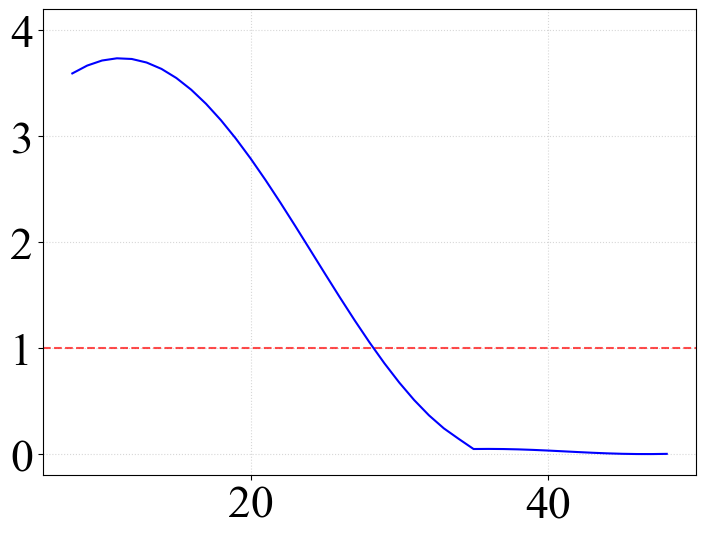

In [ ]:
R_2023 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2023).to_excel('../outcome/Result/Fit/Anhui Province.xlsx', index=False)

import statistics
median_Rt_11 = statistics.median(R_2023)
# 计算数值范围
min_value = np.min(R_2023)
max_value = np.max(R_2023)
# 计算四分位数和IQR
Q1 = np.percentile(R_2023, 25)  # 第一四分位数（25%分位数）
Q3 = np.percentile(R_2023, 75)  # 第三四分位数（75%分位数）
IQR = Q3 - Q1                   # 四分位间距

# 打印结果（保留4位小数）
print(f"第一四分位数 (Q1): {Q1:.4f}")
print(f"第三四分位数 (Q3): {Q3:.4f}")
print(f"四分位间距 (IQR): {IQR:.4f}")

# 可选：检测异常值（1.5倍IQR法则）
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = R_2023[(R_2023 < lower_bound) | (R_2023 > upper_bound)]
print(f"\n异常值边界: [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f"检测到 {len(outliers)} 个异常值: {outliers.round(4)}")

# 打印结果
print(f"R_2023 的数值范围: [{min_value:.4f}, {max_value:.4f}]")
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2023)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
# plt.ylim(-0.2, 6.8)
plt.yticks(np.arange(0, 6.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(8, 49), R_2023, 'b-')


# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.ylim(-0.2, 4.2)
plt.grid(True)
plt.savefig('../结果图/拟合结果2/R_2023.pdf', format='pdf')
plt.show()

## 2022

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2344
    # data points      = 34
    # variables        = 4
    chi-square         = 3397.12875
    reduced chi-square = 113.237625
    Akaike info crit   = 164.547062
    Bayesian info crit = 170.652504
    R-squared          = 0.73897119
[[Variables]]
    beta0:  0.10373946 +/- 0.06140634 (59.19%) (init = 0.1)
    alpha:  2.82090104 +/- 4.57437920 (162.16%) (init = 2)
    T:      52 (fixed)
    S2_0:   999992.230 +/- 1629620.93 (162.96%) (init = 10000)
    S3_0:   1000.03409 +/- 9597607.64 (959728.04%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9951
    C(alpha, S3_0)  = +0.9610
    C(beta0, alpha) = -0.6114
    C(alpha, S2_0)  = +0.5994
    C(beta0, S3_0)  = -0.4250
    C(S2_0, S3_0)   = +0.3970
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data 

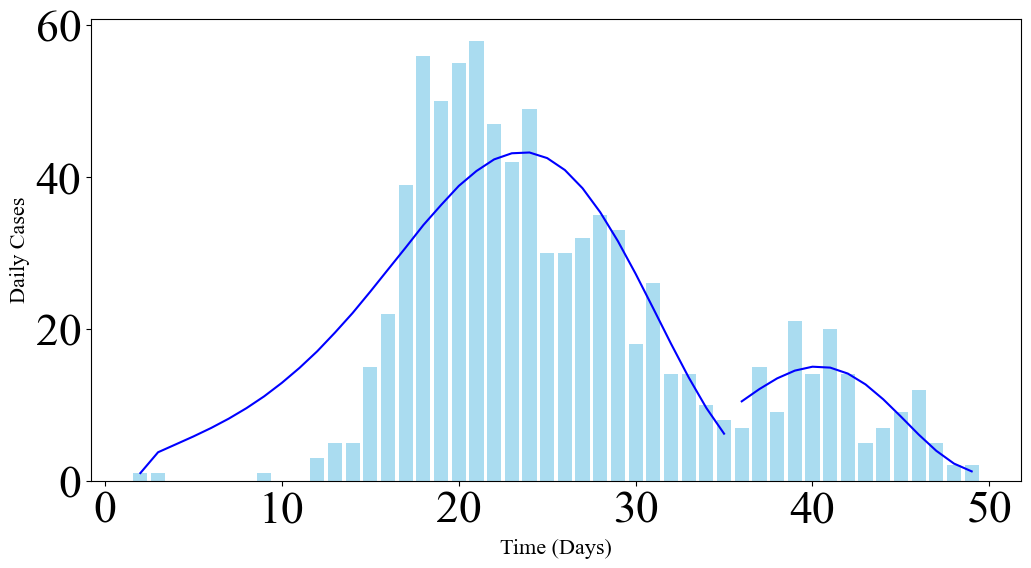

In [ ]:
observed_cases_1 = I_2022[1:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2022[35:49].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(2, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 50)  # 第二段拟合236-330日 需要比实际的第二段多一天
t_days_3 = np.arange(36, 50)  # 画图用的第二段，实际的第二段就是237-329日

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 61269999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00716
    dr1 = 0.00809
    κ = 1
    p = 0.043
    f = 0.026159
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.1, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=10000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=10000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    61269999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00716
dr1 = 0.00809
κ = 1
p = 0.043
f = 0.026159
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00716
    dr1 = 0.00809
    κ = 1
    p = 0.043
    f = 0.026159
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=35)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
# plt.legend()
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2022 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2022 = I_2022[1:49].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2022# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2022  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# # # 计算MAPE
# # mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)


MSE: 75.35395529842208
RMSE: 8.680665602269338
R-squared: 0.7517505129589175
MAE: 6.689637030300574


meta NOT subset; don't know how to subset; dropped


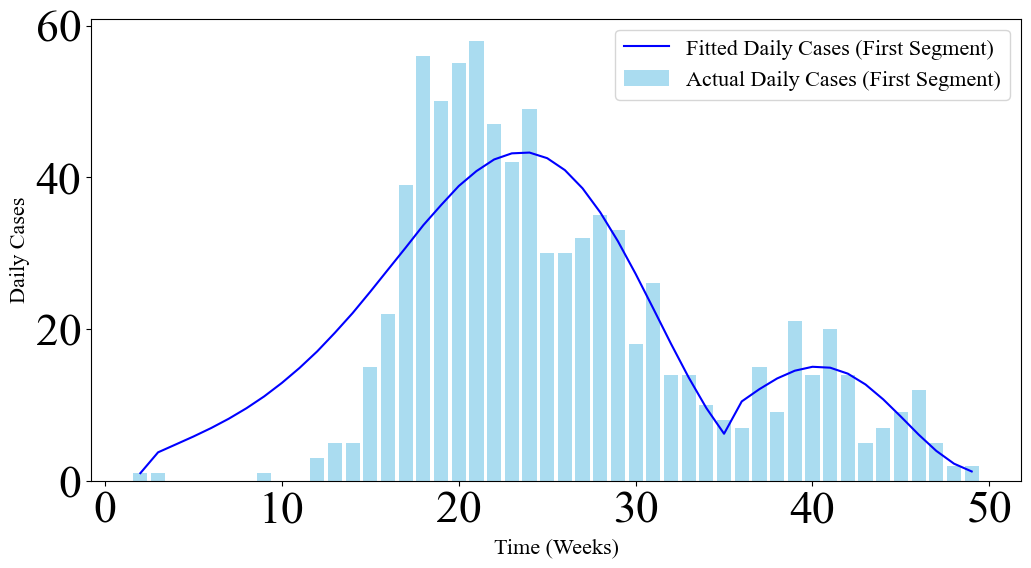

皮尔森相关系数：0.8813665611258001
p值：1.380808148910204e-16


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(2, 50), observed_cases_2022, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(2, 50), result_2022, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
# plt.ylim(-1, 31)
plt.legend()
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/2022.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2022, result_2022)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

meta NOT subset; don't know how to subset; dropped


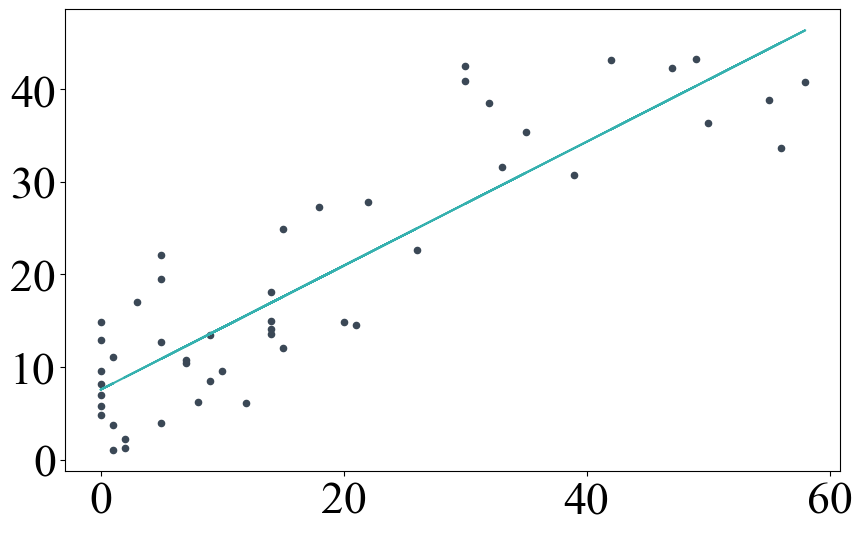

R²：0.7768070150707187


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2022)
predicted_cases = np.array(result_2022)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')

# plt.legend()
plt.savefig('./outcome/Figure/Goodness of fit/Anhui Provinces/2022.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

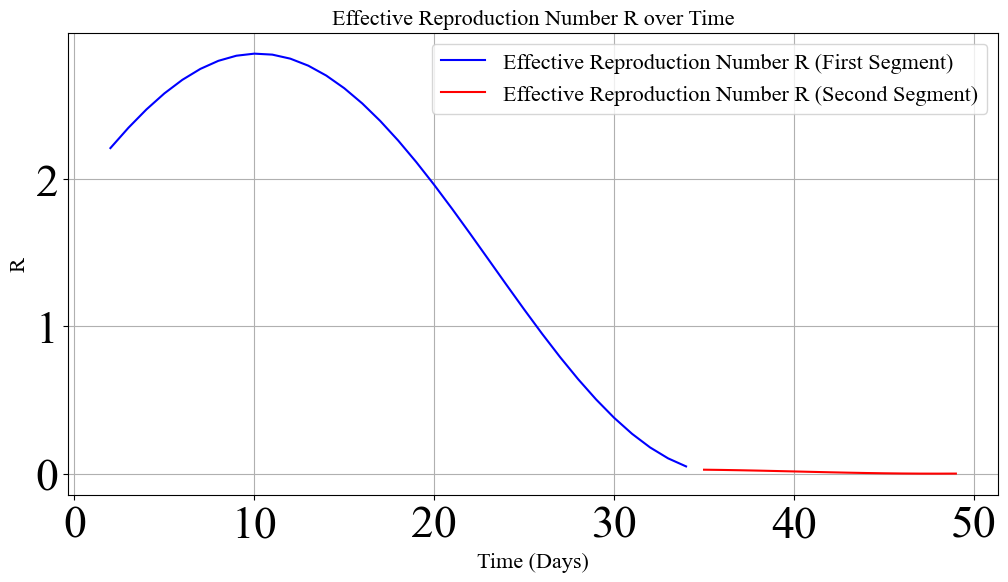

In [66]:
N1 = 61270000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(2, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

第一四分位数 (Q1): 0.0224
第三四分位数 (Q3): 2.4811
四分位间距 (IQR): 2.4587
R_2023 的数值范围: [0.0000, 2.8496]
Rt_11 的中位数为: 1.031296243173411
R_2023 的平均数为: 1.2457208579610575


meta NOT subset; don't know how to subset; dropped


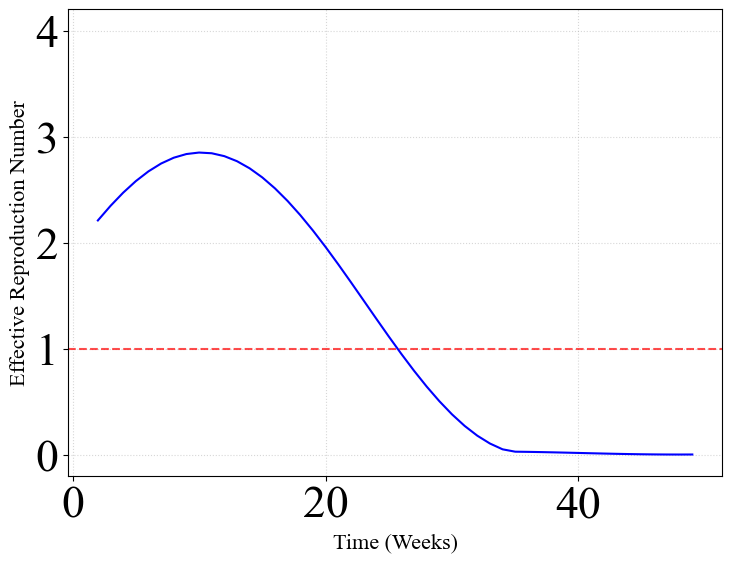

In [ ]:
R_2022 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2022).to_excel('../outcome/Result/Fit/Anhui Province/R_2022.xlsx', index=False)
import statistics
median_Rt_11 = statistics.median(R_2022)
# 计算数值范围
min_value = np.min(R_2022)
max_value = np.max(R_2022)
# 计算四分位数和IQR
Q1 = np.percentile(R_2022, 25)  # 第一四分位数（25%分位数）
Q3 = np.percentile(R_2022, 75)  # 第三四分位数（75%分位数）
IQR = Q3 - Q1                   # 四分位间距

# 打印结果（保留4位小数）
print(f"第一四分位数 (Q1): {Q1:.4f}")
print(f"第三四分位数 (Q3): {Q3:.4f}")
print(f"四分位间距 (IQR): {IQR:.4f}")


# 打印结果
print(f"R_2023 的数值范围: [{min_value:.4f}, {max_value:.4f}]")
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2022)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
# plt.ylim(-0.2, 6.8)
plt.yticks(np.arange(0, 6.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(2, 50), R_2022, 'b-')
plt.xlabel('Time (Weeks)')
plt.ylabel('Effective Reproduction Number')
plt.ylim(-0.2, 4.2)
plt.grid(True)
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/R_2022.pdf', format='pdf')
plt.show()

## 2021

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2371
    # data points      = 25
    # variables        = 4
    chi-square         = 918.004409
    reduced chi-square = 43.7144957
    Akaike info crit   = 98.0831592
    Bayesian info crit = 102.958663
    R-squared          = 0.59188195
[[Variables]]
    beta0:  0.07957942 +/- 0.05973085 (75.06%) (init = 0.1)
    alpha:  2.73859408 +/- 4.46024070 (162.87%) (init = 0.2)
    T:      52 (fixed)
    S2_0:   994724.553 +/- 2033427.52 (204.42%) (init = 10000)
    S3_0:   1010.94695 +/- 8210126.15 (812122.35%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9954
    C(alpha, S3_0)  = -0.9376
    C(beta0, alpha) = -0.3126
    C(alpha, S2_0)  = +0.2882
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 15
    # variables        = 3
    chi-square

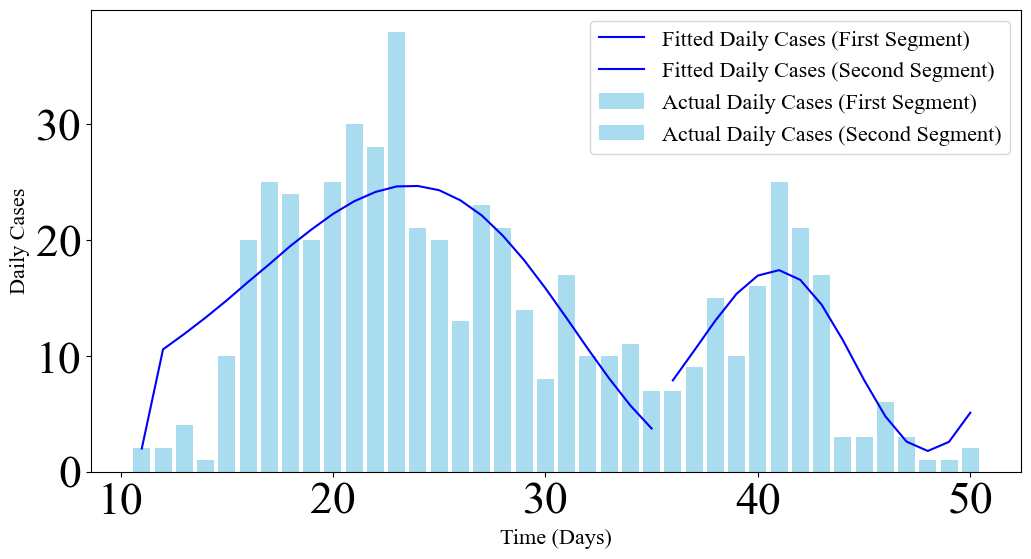

In [68]:
observed_cases_1 = I_2021[10:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2021[35:50].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 51)  # 第二段拟合236-330日 需要比实际的第二段多一天
t_days_3 = np.arange(36, 51)  # 画图用的第二段，实际的第二段就是237-329日

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 61129998  # 直接代入初始值
    I1_0 = 2        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00805
    dr1 = 0.008
    κ = 1
    p = 0.043
    f = 0.020258
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.1, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=0.2, min=0, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=10000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=10000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    61129998, 0, 0, 2, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00805
dr1 = 0.008
κ = 1
p = 0.043
f = 0.020258
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00805
    dr1 = 0.008
    κ = 1
    p = 0.043
    f = 0.020258
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=35)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2021 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2021 = I_2021[10:50].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2021# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2021  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# # # 计算MAPE
# # mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)


MSE: 28.672292716615488
RMSE: 5.354651502816545
R-squared: 0.6761816578792783
MAE: 4.21744260369068


meta NOT subset; don't know how to subset; dropped


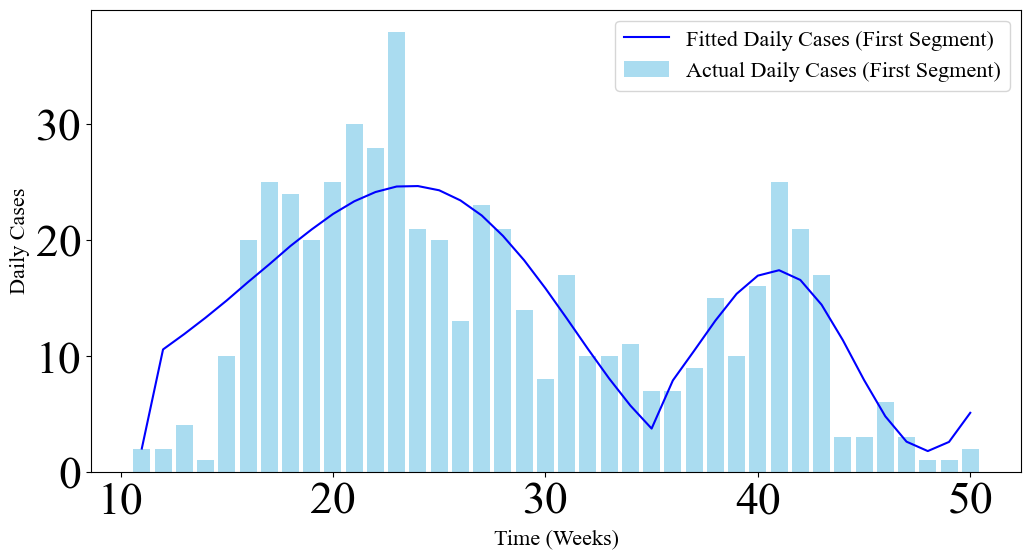

皮尔森相关系数：0.8272398572971378
p值：4.7013688049451103e-11


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 51), observed_cases_2021, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 51), result_2021, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
# plt.ylim(-1, 31)
plt.legend()
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/2021.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2021, result_2021)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

meta NOT subset; don't know how to subset; dropped


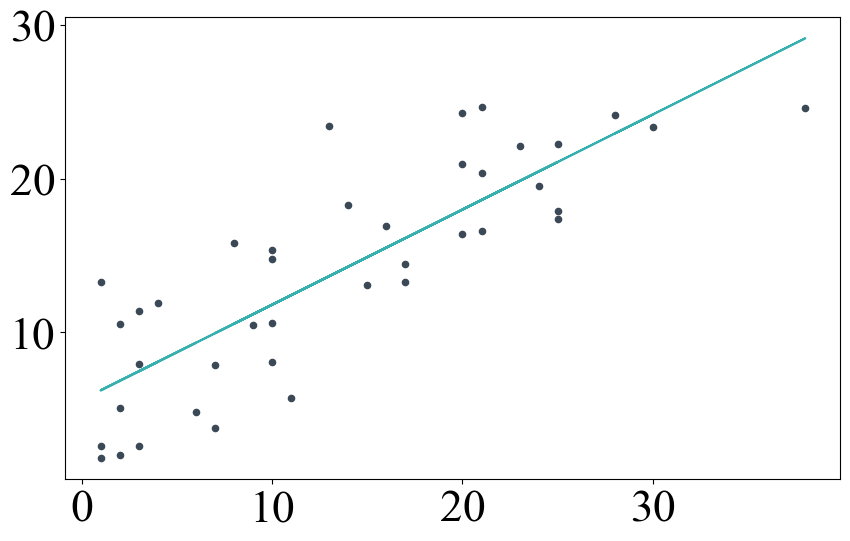

R²：0.6843257815009889


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2021)
predicted_cases = np.array(result_2021)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')

# plt.legend()
plt.savefig('../outcome/Figure/Goodness of fit/Anhui Provinces/2021.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

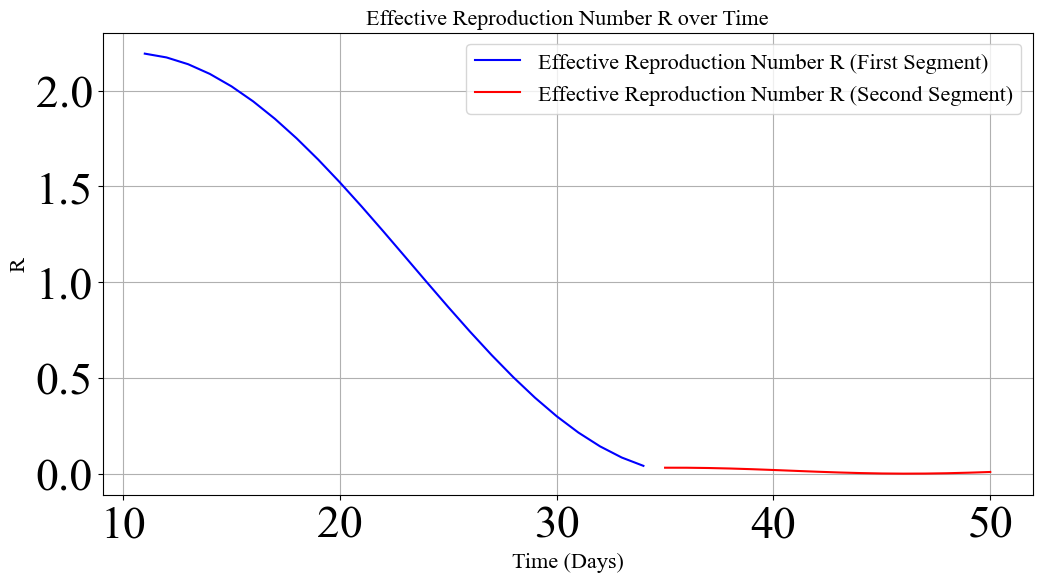

In [72]:
N1 = 61130000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

Rt_11 的中位数为: 0.25718222081713665
R_2023 的平均数为: 0.705977695005769


meta NOT subset; don't know how to subset; dropped


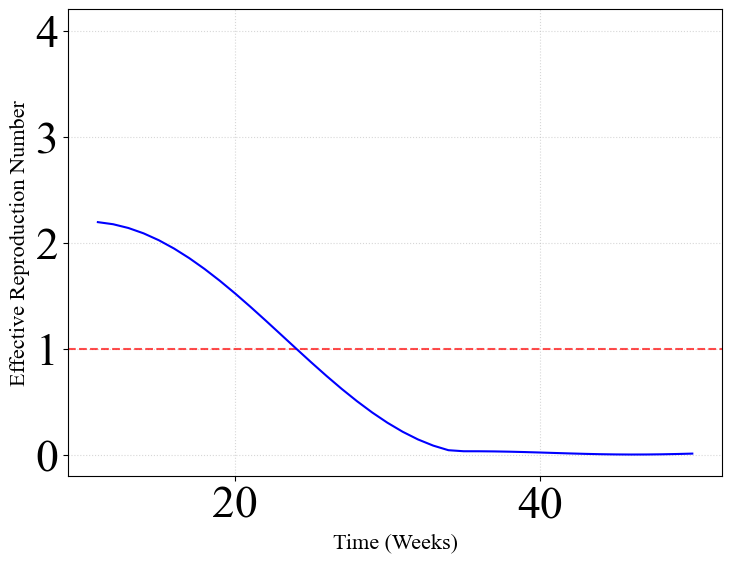

In [ ]:
R_2021 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2021).to_excel('../outcome/Result/Fit/Anhui Province/R_2021.xlsx', index=False)

import statistics
median_Rt_11 = statistics.median(R_2021)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2021)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
# plt.ylim(-0.2, 6.8)
plt.yticks(np.arange(0, 6.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(11, 51), R_2021, 'b-')
plt.xlabel('Time (Weeks)')
plt.ylabel('Effective Reproduction Number')
plt.ylim(-0.2, 4.2)
plt.grid(True)
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/R_2021.pdf', format='pdf')
plt.show()

## 2020

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1788
    # data points      = 26
    # variables        = 4
    chi-square         = 1160.72697
    reduced chi-square = 52.7603168
    Akaike info crit   = 106.766336
    Bayesian info crit = 111.798723
    R-squared          = 0.65460880
[[Variables]]
    beta0:  0.08922506 +/- 0.05895326 (66.07%) (init = 0.1)
    alpha:  2.37710063 +/- 4.18425068 (176.02%) (init = 2)
    T:      52 (fixed)
    S2_0:   999946.805 +/- 1764901.90 (176.50%) (init = 10000)
    S3_0:   1000.22097 +/- 1.2629e+08 (12625722.22%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9960
    C(alpha, S3_0)  = +0.9507
    C(beta0, alpha) = -0.4176
    C(alpha, S2_0)  = +0.3933
    C(beta0, S3_0)  = -0.1682
    C(S2_0, S3_0)   = +0.1297
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data

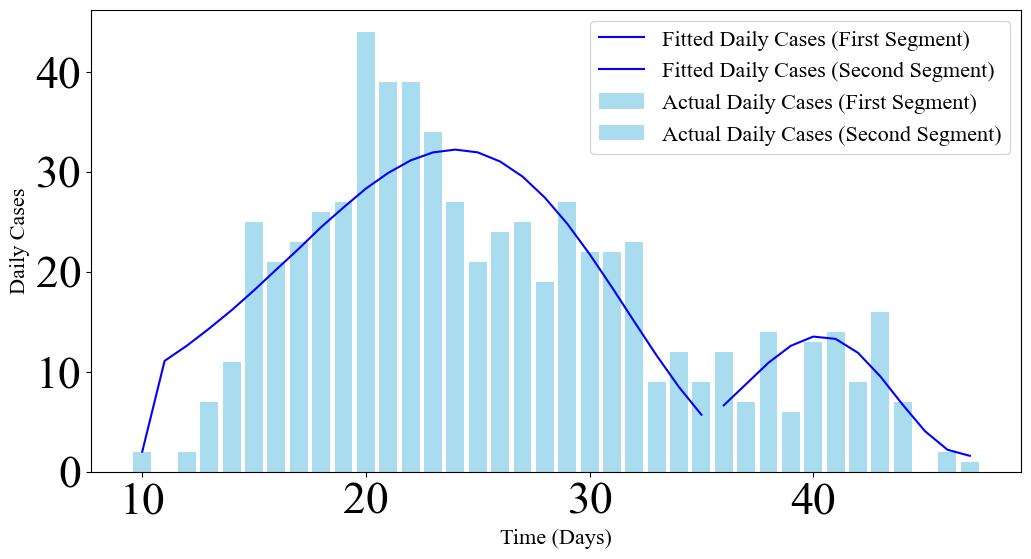

In [74]:
observed_cases_1 = I_2020[9:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2020[35:47].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(10, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 48)  # 第二段拟合236-330日 需要比实际的第二段多一天
t_days_3 = np.arange(36, 48)  # 画图用的第二段，实际的第二段就是237-329日

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 61049998  # 直接代入初始值
    I1_0 = 2        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00945
    dr1 = 0.00796
    κ = 1
    p = 0.043
    f = 0.060842
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.1, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=0, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=10000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=10000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    61049998, 0, 0, 2, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00945
dr1 = 0.00796
κ = 1
p = 0.043
f = 0.060842
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00945
    dr1 = 0.00796
    κ = 1
    p = 0.043
    f = 0.060842
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=35)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2020 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2020 = I_2020[9:47].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2020# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2020  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 34.56705405897782
RMSE: 5.879375311967915
R-squared: 0.7343330970478539
MAE: 4.512367200680536
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_1356\1148095753.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


meta NOT subset; don't know how to subset; dropped


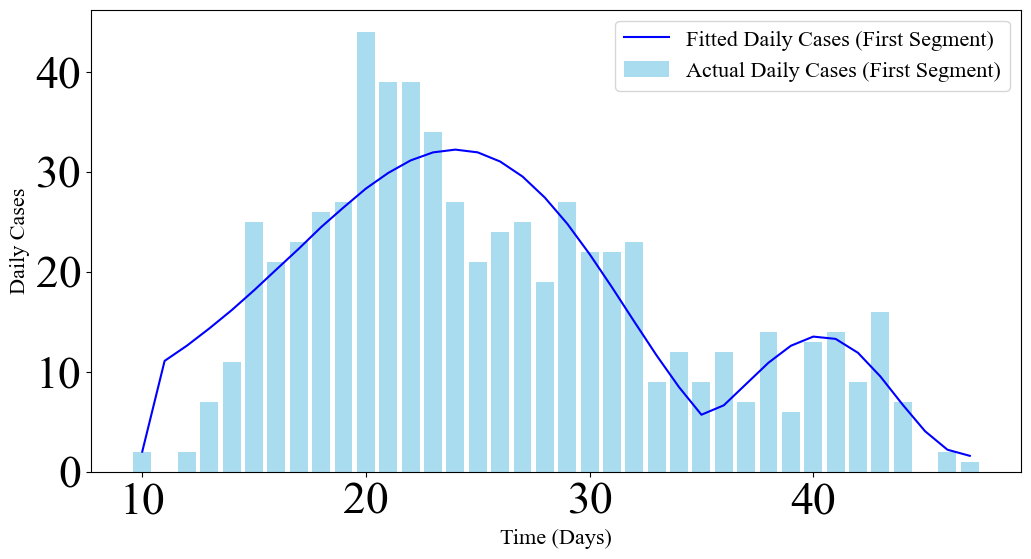

皮尔森相关系数：0.8572606558050837
p值：6.3844562229594855e-12


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(10, 48), observed_cases_2020, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(10, 48), result_2020, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
# plt.ylim(-1, 31)
plt.legend()
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/2020.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2020, result_2020)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

meta NOT subset; don't know how to subset; dropped


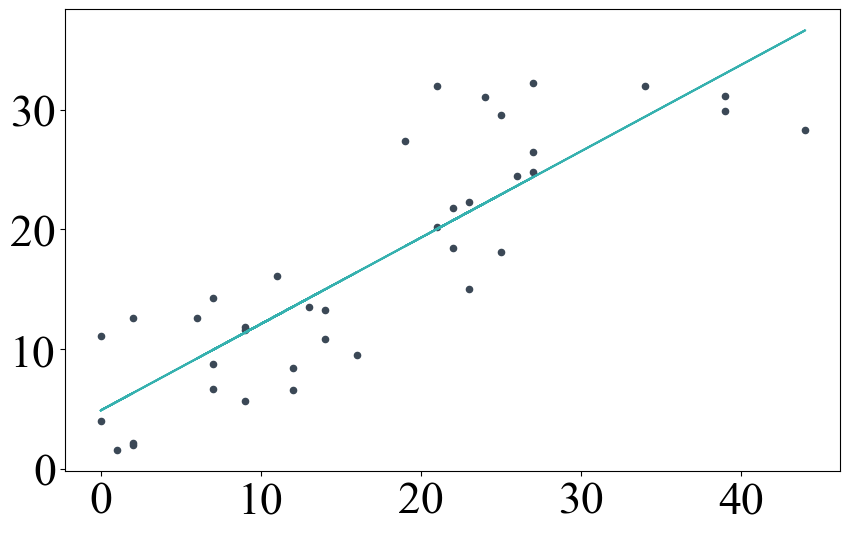

R²：0.7348958319913621


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2020)
predicted_cases = np.array(result_2020)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
# plt.xlabel('Actual Daily Cases')
# plt.ylabel('Simulated Daily Cases')
# plt.legend()
plt.savefig('../outcome/Figure/Goodness of fit/Anhui Provinces/2020.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

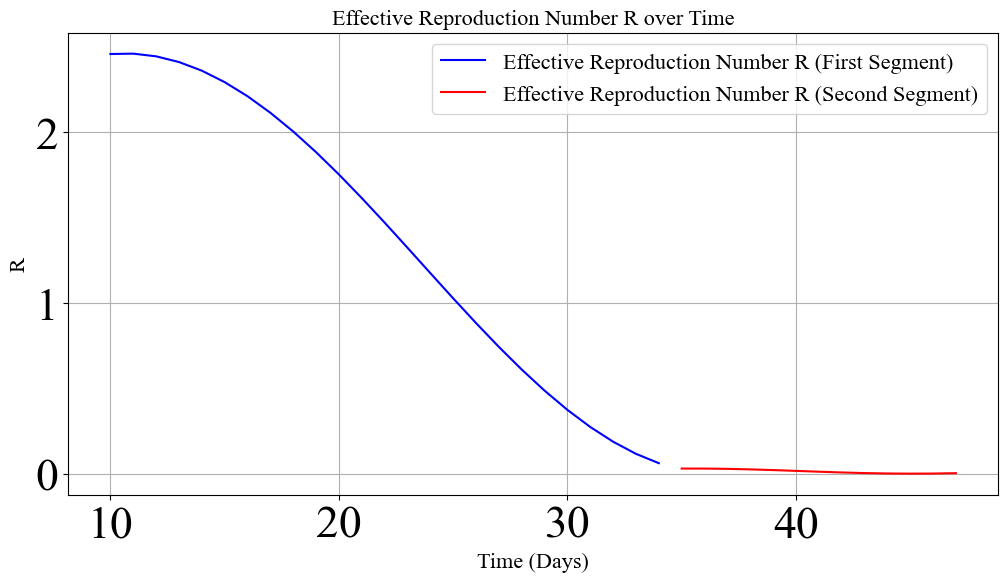

In [78]:
N1 = 61050000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(10, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

Rt_11 的中位数为: 0.5476830202519162
R_2023 的平均数为: 0.9181667370156493


meta NOT subset; don't know how to subset; dropped


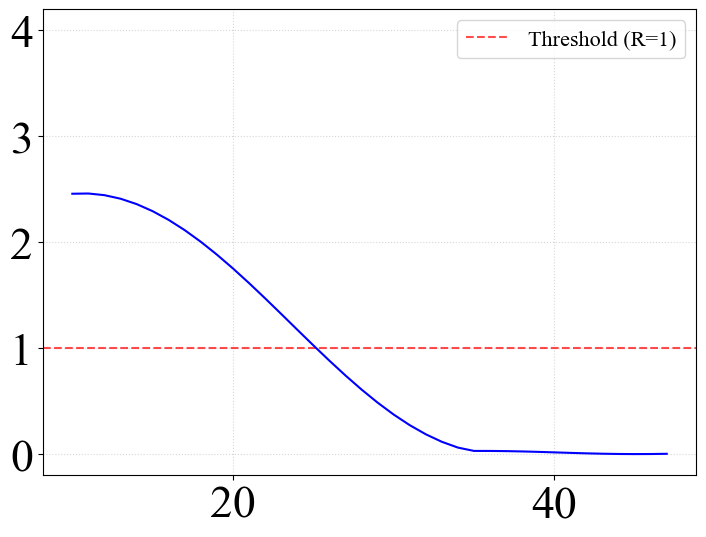

In [ ]:
R_2020 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2020).to_excel('../outcome/Result/Fit/Anhui Province/R_2020.xlsx', index=False)

plt.rcParams.update({
    'font.size': 16,          # 默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 33,    # x轴刻度标签字体大小
    'ytick.labelsize': 33,    # y轴刻度标签字体大小
    'legend.fontsize': 16     # 图例字体大小
})


import statistics
median_Rt_11 = statistics.median(R_2020)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2020)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
# plt.ylim(-0.2, 6.8)
plt.yticks(np.arange(0, 6.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(10, 48), R_2020, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.legend()
plt.ylim(-0.2, 4.2)
plt.grid(True)
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/R_2020.pdf', format='pdf')
plt.show()

## 2019

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3333
    # data points      = 35
    # variables        = 4
    chi-square         = 990.813871
    reduced chi-square = 31.9617378
    Akaike info crit   = 125.011252
    Bayesian info crit = 131.232644
    R-squared          = 0.61107077
[[Variables]]
    beta0:  0.06735679 +/- 0.04022007 (59.71%) (init = 0.1)
    alpha:  1.91339629 +/- 5.80397049 (303.33%) (init = 2)
    T:      52 (fixed)
    S2_0:   999992.631 +/- 1569502.12 (156.95%) (init = 10000)
    S3_0:   1000.01619 +/- 2014000.09 (201396.75%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9852
    C(alpha, S3_0)  = +0.9672
    C(beta0, alpha) = -0.6449
    C(alpha, S2_0)  = +0.5654
    C(beta0, S3_0)  = -0.4941
    C(S2_0, S3_0)   = +0.3845
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 160
    # data 

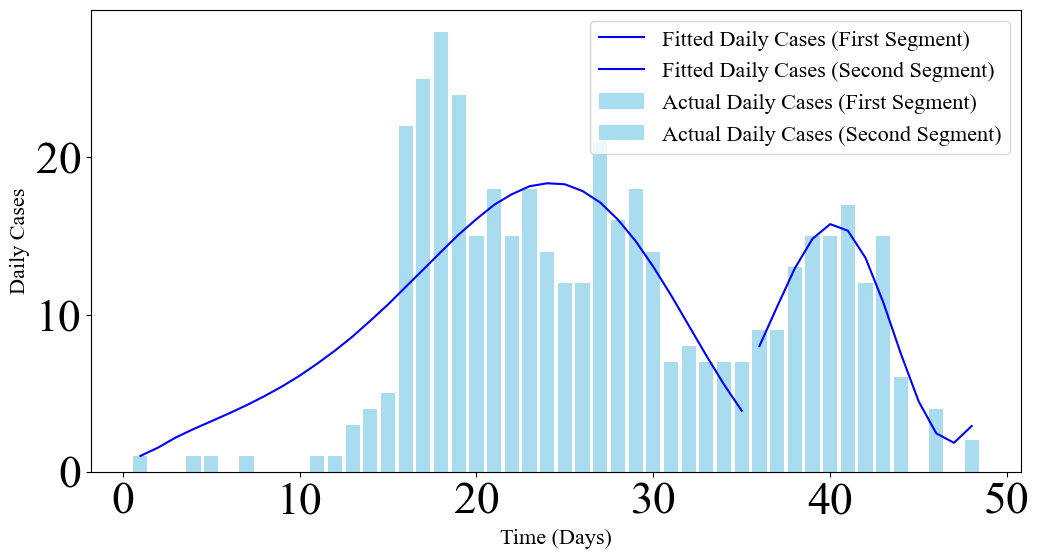

In [80]:
observed_cases_1 = I_2019[0:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2019[35:48].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(1, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 49)  # 第二段拟合236-330日 需要比实际的第二段多一天
t_days_3 = np.arange(36, 49)  # 画图用的第二段，实际的第二段就是237-329日

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 60919999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01203
    dr1 = 0.00604
    κ = 1
    p = 0.043
    f = 0.036117
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.1, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=10000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=10000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    60919999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.01203
dr1 = 0.00604
κ = 1
p = 0.043
f = 0.036117
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.01203
    dr1 = 0.00604
    κ = 1
    p = 0.043
    f = 0.036117
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=35)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2019 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2019 = I_2019[0:48].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2019# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2019  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 21.807310611085228
RMSE: 4.669829826780118
R-squared: 0.6499721780376586
MAE: 3.4778311829695987
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_1356\678853764.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


meta NOT subset; don't know how to subset; dropped


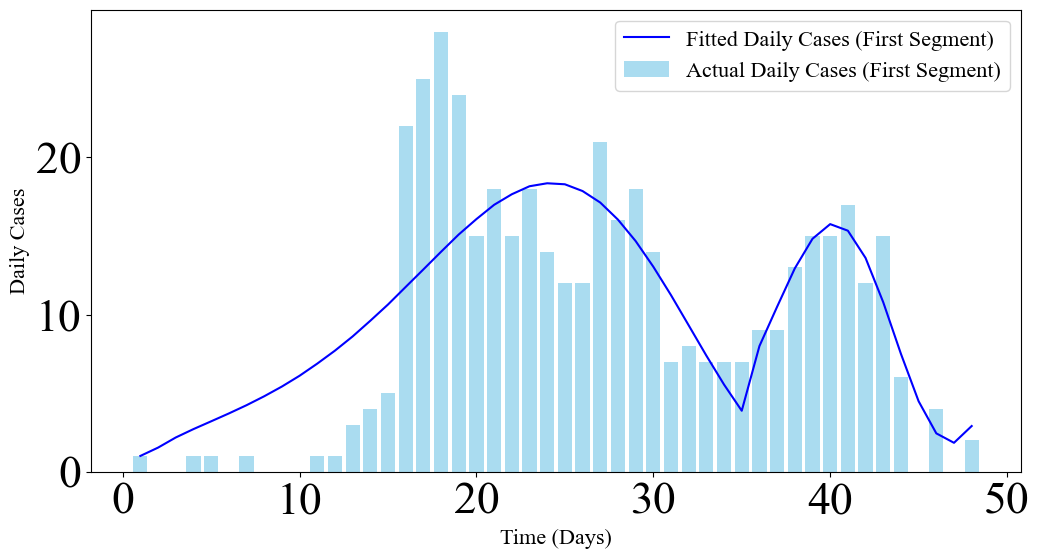

皮尔森相关系数：0.8203557897924179
p值：9.660558793589856e-13


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(1, 49), observed_cases_2019, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(1, 49), result_2019, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
# plt.ylim(-1, 31)
plt.legend()
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/2019.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2019, result_2019)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
meta NOT subset; don't know how to subset; dropped


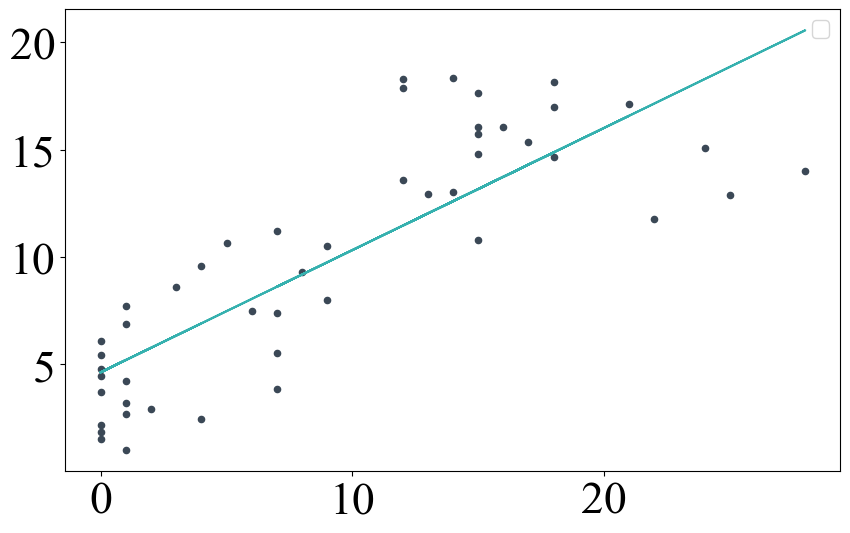

R²：0.6729836218459418


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2019)
predicted_cases = np.array(result_2019)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
# plt.xlabel('Actual Daily Cases')
# plt.ylabel('Simulated Daily Cases')
plt.legend()
plt.savefig('../outcome/Figure/Goodness of fit/Anhui Provinces/2019.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

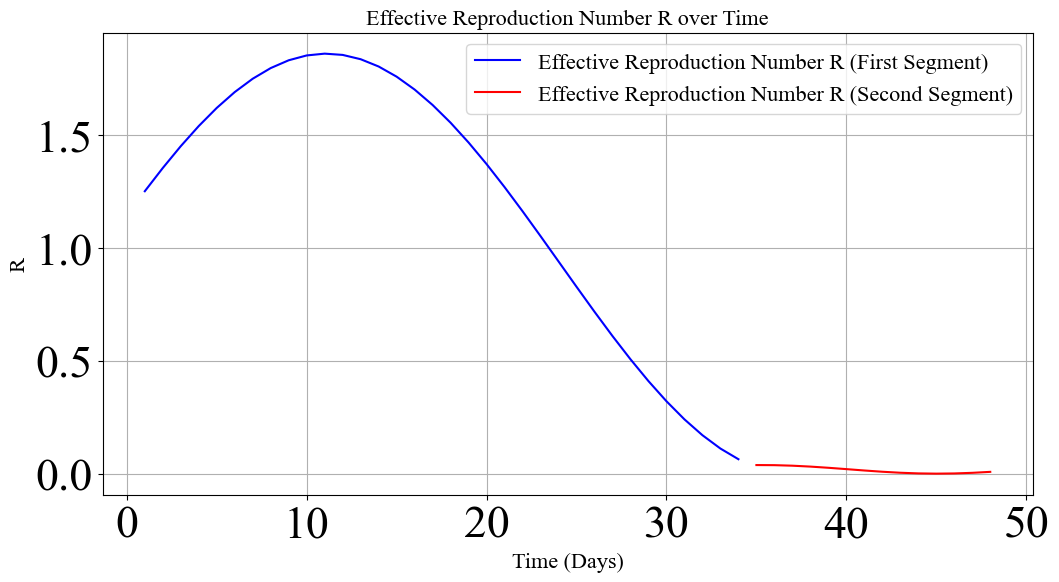

In [84]:
N1 = 60920000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(1, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

Rt_11 的中位数为: 0.8841484238230233
R_2023 的平均数为: 0.866991439719578


meta NOT subset; don't know how to subset; dropped


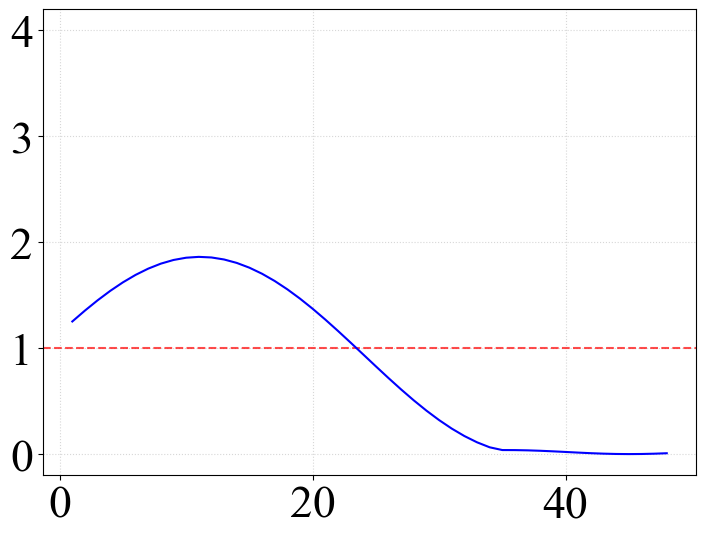

In [ ]:
R_2019 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2019).to_excel('./outcome/Result/Fit/Anhui Province/R_2019.xlsx', index=False)

import statistics
median_Rt_11 = statistics.median(R_2019)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2019)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
# plt.ylim(-0.2, 6.8)
plt.yticks(np.arange(0, 6.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(1, 49), R_2019, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.ylim(-0.2, 4.2)
# plt.grid(True)
plt.savefig('../outcome/Figure/Fit/Anhui Provinces/R_2019.pdf', format='pdf')
plt.show()